**DIY FACIAL RECOGNITION MODELING SCRIPT**<BR>
This file allows the user to focus on modeling, rather than image collection and processing, by importing the downstream data files generated by the FaceRecog.jpynb script. There are similarities between these two scripts, but this file is faster and doesn't process any of the image files. Instead, it simply grabs pre-processed data, in the form of a csv file containing Euclidean distances which are calculated from the original image files.

In [1]:
#################
# IMPORT PACKAGES
#################

import pandas as pd
import numpy as np
import random

# predictive modeling
from sklearn.ensemble import RandomForestClassifier

# for KNN block
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline

# for confusion matrices
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#!pip install pathlib
import pathlib

# For visualizations
from plotnine import *

In [2]:
###################################################################################################################################
# LOCAL VARIABLES: YOU SHOULD NOT NEED TO CHANGE THESE, ASSUMING YOU HAVE UNZIPPED THE FILES AND NOT MOVED ANY ACCOMPANYING FOLDERS
###################################################################################################################################

# because I use dark mode, I use a contrasting color when printing text against the background. You can change this here
textColor = "#cccccc"

# the random forest seed that was used with the most current test/train data in the latest FaceRecog.jpynb file (the one that generated the latest csv file)
bestRandomForestSeed = 117602602  # 92.95%

# the number of images to use 
targetImagesPerPerson = 110

# tells program whether to use the pre-saved, best train/test split
getTrainTestFromFile = True

# path where .csv file can be found
srcFolder = pathlib.Path("FaceRecog_FromCSV.ipynb").parent.resolve()

# paths to train and test data
pathToDistances = "distances.csv"
pathToPoints    = "points.csv"
newTrainSavePath = "train.csv"
newTestSavePath = "test.csv"

In [3]:
################
# GET SAVED DATA
################

# get all data
allDistances = pd.read_csv(pathToDistances)
newCols = allDistances.columns[1:len(allDistances.columns)] # remember the columns we want to keep
allDistances.set_index("Unnamed: 0", inplace=False) # reset the index to the first column's values
allDistances = allDistances[newCols] # remove the old index column

# get train
newTrainDist = pd.read_csv(newTrainSavePath)
newCols = newTrainDist.columns[1:len(newTrainDist.columns)] # remember the columns we want to keep
newTrainDist.set_index("Unnamed: 0", inplace=False) # fix columns
newTrainDist = newTrainDist[newCols] # remove the old index column

# get test data
newTestDist = pd.read_csv(newTestSavePath)
newTestDist.set_index("Unnamed: 0", inplace=False)
newTestDist = newTestDist[newCols] # remove the old index column

# separate train into x and y variables 
y_train = newTrainDist["personID"]
X_train = newTrainDist[newTrainDist.columns[2:len(newTrainDist.columns)]]

# separate test into x and y variables 
y_test = newTestDist["personID"]
X_test = newTestDist[newTestDist.columns[2:len(newTestDist.columns)]]

In [4]:
##########################################################################################################################
# SCRUB: CLEAN UP DIFFERENT PERSON NAMES
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

# determine which columns we reall need
colsToKeep = ["person"] + list(allDistances.columns[2:len(allDistances.columns)])

ad = allDistances[colsToKeep]                       # get a local copy of allDistances df
ad["person"] = ad["person"].apply(str.lower)        # change case of person to lower

# fix person names where they are duplicates
ad["person"][ad["person"] == "sandras"] = "sandys"  
ad["person"][ad["person"] == "andrew"] = "andrewd"  
ad["person"][ad["person"] == "anniet"] = "annieti"  
ad["person"][ad["person"] == "davidl"] = "davidla"  
ad["person"][ad["person"] == "garenm"] = "garenmo"  
ad["person"][ad["person"] == "jiebin"] = "jiebinz"  
ad["person"][ad["person"] == "joshua"] = "joshuab"  
ad["person"][ad["person"] == "karltr"] = "karltre"  
ad["person"][ad["person"] == "katieh"] = "katieha"  
ad["person"][ad["person"] == "leiche"] = "leichen"  
ad["person"][ad["person"] == "nickwa"] = "nickwai"
ad["person"][ad["person"] == "noahla"] = "noahlar"
ad["person"][ad["person"] == "noefer"] = "noefern"
ad["person"][ad["person"] == "sethri"] = "sethris"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [5]:
##########################################################################################################################
# TRANSFORM:  TURN person COLUMN INTO personID COLUMN
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

ad = ad.sort_values(by="person")                    # sort by person
p = ad["person"].unique()                           # get one copy of each person
i = list(range(0,len(p)))                           # get an index for the table that will translate people into numbers
pID = pd.DataFrame(data=p, index=i)
pID.columns = ["person"]
pID['personID'] = pID.index

ad = pd.merge(ad, pID, how="inner", on="person")
ad = ad[["personID"] + list(ad.columns[1:len(ad.columns)-1])]

# take a look at the transformed data frame
ad.head()

,personID,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_126,dist_127,dist_128,dist_129,dist_130,dist_131,dist_132,dist_133,dist_134,dist_135
0,0,173.994253,187.856328,158.050625,178.241409,165.529454,170.815690,165.000000,155.080624,155.913438,...,111.305885,121.494856,142.284925,109.224539,90.022219,117.341382,50.089919,120.332872,92.195445,114.109596
1,0,154.945152,181.231896,140.698259,170.064694,157.000000,169.446157,167.585799,157.292721,168.023808,...,111.198022,110.860272,129.003876,97.416631,91.197588,103.097042,62.096699,104.809351,94.429868,100.603181
2,0,177.132719,189.763010,155.116086,175.262660,163.975608,171.723615,167.523133,156.064089,166.207701,...,101.833197,113.534136,129.034879,105.385008,86.005814,112.929181,52.345009,112.641023,87.005747,105.304321
3,0,184.390889,195.601636,164.109719,181.727818,171.432202,179.724790,179.178682,166.709328,168.576392,...,105.990566,131.244047,128.097619,113.745330,87.051709,120.166551,55.901699,128.444541,88.814413,122.588743
4,0,171.592541,195.058965,152.069063,176.638048,162.542302,171.420536,169.685002,153.495928,165.511329,...,95.603347,120.415946,117.613775,108.295891,79.762146,113.053085,50.596443,114.982607,80.062476,109.293184


In [6]:
##########################################################################################################################
# SCRUB: REMOVE ANY PERSONS WHO DON'T HAVE A MINIMUM NUMBER OF IMAGES
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

personsRemoved = pID.copy(deep=True)

# for each person, make sure there are a minimum number of images
for i in pID["personID"]:
    # get the number of images we have for this person
    c = len(ad[ad["personID"] == i])
    # if we have fewer than the minimum number, remove that person from the data
    if c < targetImagesPerPerson: 
        ad = ad[ad["personID"] != i]
    else: 
        # otherwise, note down the fact that they won't have their image removed
        personsRemoved = personsRemoved[personsRemoved["personID"] != i]
        # get ids we'll cull (and leave as many as we need to build a good model)
        imagesToCull = random.sample(list(ad.index[ad["personID"] == i]), c-targetImagesPerPerson)
        
        prsn = pID["person"][i]

        print("We will remove {} images from {}. Previous total was {}".format(len(imagesToCull), prsn, c))
        # remove the extra images
        ad.drop(imagesToCull, inplace=True)


print("\n\nAll images were removed for the following individuals due to insufficient number of images:\n{}".format(personsRemoved))



We will remove 16 images from andrewd. Previous total was 126
We will remove 31 images from annieti. Previous total was 141
We will remove 4 images from christi. Previous total was 114
We will remove 23 images from davidla. Previous total was 133
We will remove 29 images from farahin. Previous total was 139
We will remove 9 images from garenmo. Previous total was 119
We will remove 121 images from jessika. Previous total was 231
We will remove 151 images from jiebinz. Previous total was 261
We will remove 143 images from jonfox. Previous total was 253
We will remove 16 images from joshuab. Previous total was 126
We will remove 426 images from karltre. Previous total was 536
We will remove 263 images from katieha. Previous total was 373
We will remove 114 images from leichen. Previous total was 224
We will remove 88 images from matthew. Previous total was 198
We will remove 59 images from nickwai. Previous total was 169
We will remove 154 images from noahlar. Previous total was 264
We w

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
################################
# EXPLORE: PREVIEW ALL DISTANCES
################################
ad.head()

,personID,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_126,dist_127,dist_128,dist_129,dist_130,dist_131,dist_132,dist_133,dist_134,dist_135
0,0,173.994253,187.856328,158.050625,178.241409,165.529454,170.815690,165.000000,155.080624,155.913438,...,111.305885,121.494856,142.284925,109.224539,90.022219,117.341382,50.089919,120.332872,92.195445,114.109596
1,0,154.945152,181.231896,140.698259,170.064694,157.000000,169.446157,167.585799,157.292721,168.023808,...,111.198022,110.860272,129.003876,97.416631,91.197588,103.097042,62.096699,104.809351,94.429868,100.603181
3,0,184.390889,195.601636,164.109719,181.727818,171.432202,179.724790,179.178682,166.709328,168.576392,...,105.990566,131.244047,128.097619,113.745330,87.051709,120.166551,55.901699,128.444541,88.814413,122.588743
4,0,171.592541,195.058965,152.069063,176.638048,162.542302,171.420536,169.685002,153.495928,165.511329,...,95.603347,120.415946,117.613775,108.295891,79.762146,113.053085,50.596443,114.982607,80.062476,109.293184
5,0,167.107750,209.121974,157.892368,194.177754,175.547714,187.296556,179.824915,155.241747,170.496334,...,105.621967,124.338248,130.391718,112.071406,87.321246,115.121675,54.129474,114.934764,88.294960,112.111552


In [8]:
###################################################################################
# REPORTING: BUILD RANDOM FOREST
# note: this uses pre-loaded train/test data, NOT the allDistances or ad dataframes
###################################################################################

forest = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = np.random.seed(bestRandomForestSeed))
forest.fit(X=X_train, y=y_train)
predictions = forest.predict(X_test)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = pd.DataFrame({"test":y_test, "predict":list(predictions)})
df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

print("Result: {}% correct".format(round(sum(dfCorrect["correct"])/sum(dfCorrect["total"]) * 100, 2)))

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, predictions))

Result: 92.95% correct
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 21  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 18  1  0  0  0  1  0  0  0  0  0  0  1]
 [ 0  2  0  1  0  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 20  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  1  0  0  0  0  0 17  1  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0 20  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 

,correctName,correct,total,pctCorrect,Model
0,andrewd,22,22,100.00,Random Forest
1,annieti,19,22,86.36,Random Forest
2,christi,22,22,100.00,Random Forest
3,davidla,20,22,90.91,Random Forest
4,farahin,22,22,100.00,Random Forest
5,garenmo,21,22,95.45,Random Forest
6,jessika,21,22,95.45,Random Forest
7,jiebinz,18,22,81.82,Random Forest
8,jonfox,18,22,81.82,Random Forest
9,joshuab,22,22,100.00,Random Forest


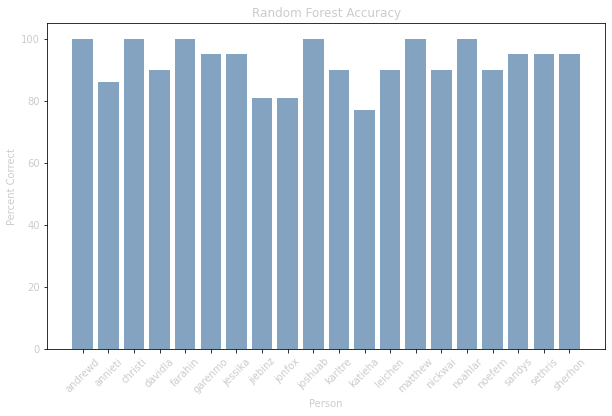

In [23]:
# Random forest accuracy

# create bar plot of random forest accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("Random Forest Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfRandomForest = dfCorrect.copy()
dfRandomForest['Model']='Random Forest'
dfRandomForest


**Random Forest Notes**<br>
Random forest was the winner for the Euclidean Distance data. With 100% correct classification for several persons, and a mean success rate ~86% with models generated at random. 

In [24]:
###################################################################################
# MODELING 2: TRY BAYESIAN MODEL
# note: this uses pre-loaded train/test data, NOT the allDistances or ad dataframes
###################################################################################

# MODEL
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train, y_train)

# Make predictions
predictions = gnb.predict(X_test)

# print accuracy
print(accuracy_score(y_test, predictions) * 100)

bayesPredictions = pd.DataFrame({"test":y_test, "predict":list(predictions)})

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, predictions))

65.45454545454545
[[10  0  0  0  1  4  0  0  0  0  0  1  0  1  0  1  0  4  0  0]
 [ 0 13  0  5  0  0  0  1  1  0  0  1  0  0  0  1  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  0  0]
 [ 5  2  0 10  0  0  1  1  0  0  0  0  1  0  0  1  0  1  0  0]
 [ 0  1  0  0 18  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 2  0  0  1  0 18  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  4  0  2  0  2  6  0  4  0  0  1  0  0  0  0  1  1  1  0]
 [ 0  0  0  0  0  1  0  7  0  2  3  0  0  3  0  1  4  0  1  0]
 [ 0  0  0  1  0  0  0  0 17  0  0  2  0  1  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0 20  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2 12  0  0  1  0  0  7  0  0  0]
 [ 0  3  0  1  0  0  0  1  0  0  2  8  0  0  1  2  2  0  2  0]
 [ 0  0  1  0  0  0  0  1  0  0  0  0 14  0  1  0  1  0  0  4]
 [ 1  0  0  0  0  0  0  0  0  0  0  1  0 19  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  1  1  2 11  2  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0

Result: 65.45% correct


,correctName,correct,total,pctCorrect,Model
0,andrewd,10,22,45.45,Bayes
1,annieti,13,22,59.09,Bayes
2,christi,19,22,86.36,Bayes
3,davidla,10,22,45.45,Bayes
4,farahin,18,22,81.82,Bayes
5,garenmo,18,22,81.82,Bayes
6,jessika,6,22,27.27,Bayes
7,jiebinz,7,22,31.82,Bayes
8,jonfox,17,22,77.27,Bayes
9,joshuab,20,22,90.91,Bayes


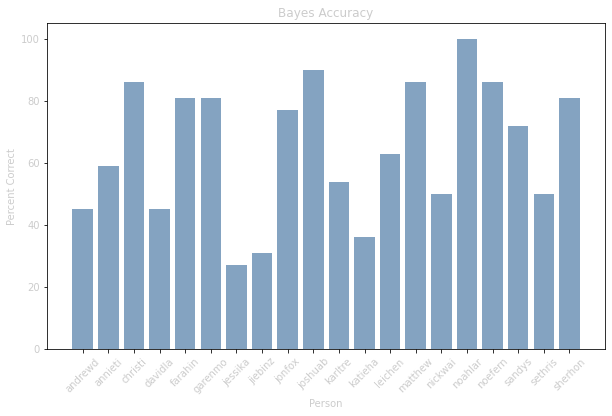

In [25]:
########################################
# REPORTING: BAYESIAN ACCURACY BY PERSON
########################################

df = bayesPredictions.copy(deep=True)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

print("Result: {}% correct".format(round(sum(dfCorrect["correct"])/sum(dfCorrect["total"]) * 100, 2)))

# create bar plot of Bayes accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("Bayes Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfBayes = dfCorrect.copy()
dfBayes['Model']='Bayes'
dfBayes


**Note**<br>
Everything below (KNN) is created from the allDistances data that is loaded in at the top of this file. This is as opposed to the train/test data, which is pre-loaded and used for the Bayesian and Random Forest models. Ultimately, everything was derived from the same dataset. It is simply faster, and easier to reliably recreate the other models, with the pre-loaded train/test data.

In [26]:
#####################
# MODELING 3: TRY KNN
#####################
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html

neighbors = 3

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=neighbors)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

yhat = nca_pipe.predict(X_test)

y_yhat = pd.DataFrame({"test":y_test, "predict":yhat})
y_yhat["result"] = y_yhat["test"] == y_yhat["predict"]
y_yhat["result"] = y_yhat["result"].astype(int)

print("Result: {}% correct".format(round(sum(y_yhat["result"])/len(y_yhat)*100, 2)))

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, yhat))

Result: 85.91% correct
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0 17  0  2  0  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1 19  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 18  0  2  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  1  1 11  0  1  0  0  2  1  1  0  2  0  0  0]
 [ 0  1  0  0  0  2  0  0 16  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0 18  0  0  0  0  2  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  1  0  0 15  1  0  0  0  1  0  1  1]
 [ 0  0  1  0  0  0  0  0  0  0  1  2 18  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  1  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 

Result: 85.91% correct


,correctName,correct,total,pctCorrect,Model
0,andrewd,20,22,90.91,kNN
1,annieti,17,22,77.27,kNN
2,christi,22,22,100.00,kNN
3,davidla,19,22,86.36,kNN
4,farahin,21,22,95.45,kNN
5,garenmo,21,22,95.45,kNN
6,jessika,18,22,81.82,kNN
7,jiebinz,11,22,50.00,kNN
8,jonfox,16,22,72.73,kNN
9,joshuab,22,22,100.00,kNN


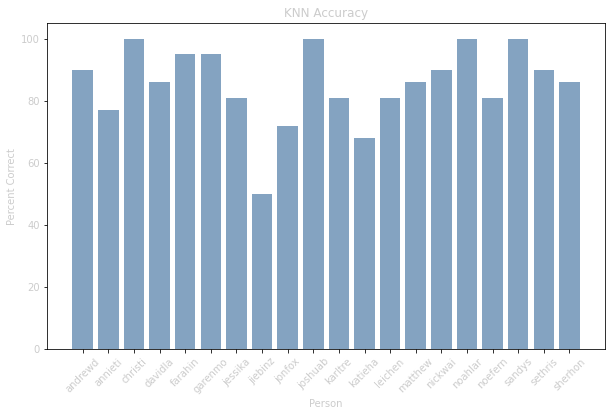

In [27]:
###################################
# REPORTING: KNN ACCURACY BY PERSON
###################################

df = y_yhat.copy(deep=True)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)

print("Result: {}% correct".format(round(sum(y_yhat["result"])/len(y_yhat)*100, 2)))
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

# create bar plot of KNN accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("KNN Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfkNN = dfCorrect.copy()
dfkNN['Model']='kNN'
dfkNN

**Questions about all models**<br>
Does accuracy have anything to do with how close the person sits to the camera? This might be a theory why Karl and Katie failed so badly in the Bayes model and why Noe's images also seem hard to load and identify.

How does the addition of a person affect the accuracy of the Euclidean distance models? Going from 10 to 11 persons, the accuracy of the Random Forest model dropped by about 1.5%

In [28]:
# Merge the model accuracy data
frames = [dfRandomForest,dfBayes,dfkNN]
models = pd.concat(frames)
models.head()

,correctName,correct,total,pctCorrect,Model
0,andrewd,22,22,100.00,Random Forest
1,annieti,19,22,86.36,Random Forest
2,christi,22,22,100.00,Random Forest
3,davidla,20,22,90.91,Random Forest
4,farahin,22,22,100.00,Random Forest


In [53]:
# Read in model accuracy table
models = pd.read_csv("Accuracy_Model1.csv", sep = ',')
models.head()

,Shorthand,pctCorrect,Model
0,andrewd,95.45,Random Forest
1,annieti,72.73,Random Forest
2,christi,100.00,Random Forest
3,davidla,95.45,Random Forest
4,farahin,100.00,Random Forest


# Visualizations

In [51]:
roster = pd.read_csv("Roster_Export_-_2022-0112_IST_718_Big_Data_Analytics.csv", sep = ',')
roster.head()

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground
0,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None
1,Christian,Bendillo,Christian Bendillo,christi,No,Headphones,No,Yes,Dark,Short,None
2,Joshua,Biggs-Bauer,Joshua Biggs-Bauer,joshuab,No,Ear buds,No,No,Dark,Short,Blurred
3,Lei,Cheng,Lei Cheng,leichen,Yes,Headphones,No,No,Dark,Short,None
4,Farahin,Choudhury,Farahin Choudhury,farahin,No,None,No,No,Dark,Long,None


In [32]:
# Create a function that creates a dataframe of count of selected attribute
# Required inputs:
#    df - dataframe name
#    attribute - string of column name

def attribute_count(df,attribute):
  count = df.groupby([attribute])
  count = count.size().to_frame(name='counts')
  count.index.name = attribute
  count.reset_index(inplace=True)
  return count

In [33]:
# Create dataframe summarizing glasses by count
glasses_count = attribute_count(roster,'Glasses')
glasses_count

,Glasses,counts
0,No,11
1,Yes,9


In [35]:
# Create dataframe summarizing listening device by count
listening_device_count = attribute_count(roster,'ListeningDevice')
listening_device_count

,ListeningDevice,counts
0,Ear buds,8
1,Headphones,4
2,None,8


In [36]:
# Create dataframe summarizing hat by count
hat_count = attribute_count(roster,'Hat')
hat_count

,Hat,counts
0,No,18
1,Yes,2


In [37]:
# Create dataframe summarizing facial hair by count
facial_hair_count = attribute_count(roster,'FacialHair')
facial_hair_count

,FacialHair,counts
0,No,16
1,Yes,4


In [38]:
# Create dataframe summarizing hair color by count
hair_color_count = attribute_count(roster,'HairColor')
hair_color_count

,HairColor,counts
0,Dark,12
1,Light,5
2,None,3


In [39]:
# Create dataframe summarizing hair length by count
hair_length_count = attribute_count(roster,'HairLength')
hair_length_count

,HairLength,counts
0,Bald,3
1,Long,4
2,Medium,1
3,Ponytail,1
4,Short,11


In [40]:
# Create dataframe summarizing zoom background by count
zoom_background_count = attribute_count(roster,'ZoomBackground')
zoom_background_count

,ZoomBackground,counts
0,Blurred,3
1,Image,2
2,None,15


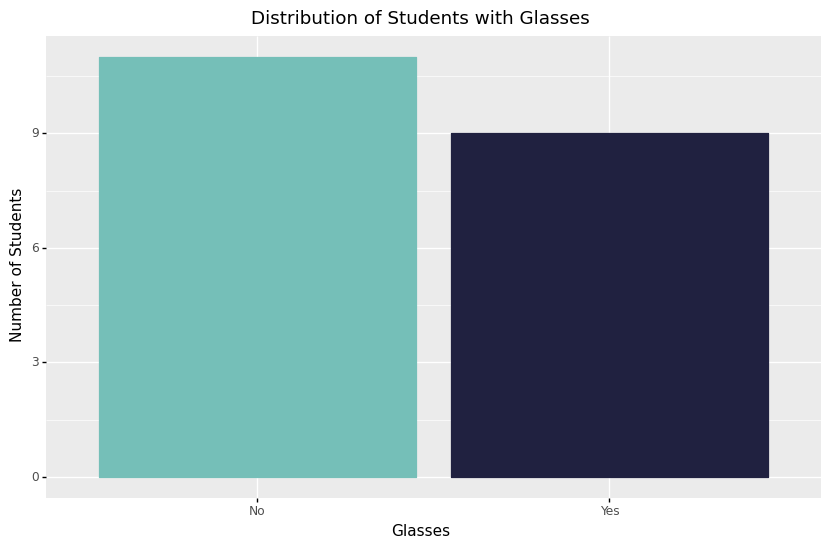

<ggplot: (8794709259174)>

In [41]:
# Visualization of students with/without glasses

# Creates Color Scales
color_scale = ['#75bfb8','#202140']

# Creates Bar Charts Primary Colors
glasses = (
    ggplot(glasses_count) 
    + aes(x = 'Glasses', y = 'counts',color='Glasses',fill='Glasses')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students with Glasses", x="Glasses", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
    + scale_y_continuous()
)
glasses
#ggsave(glasses,'glasses.png')

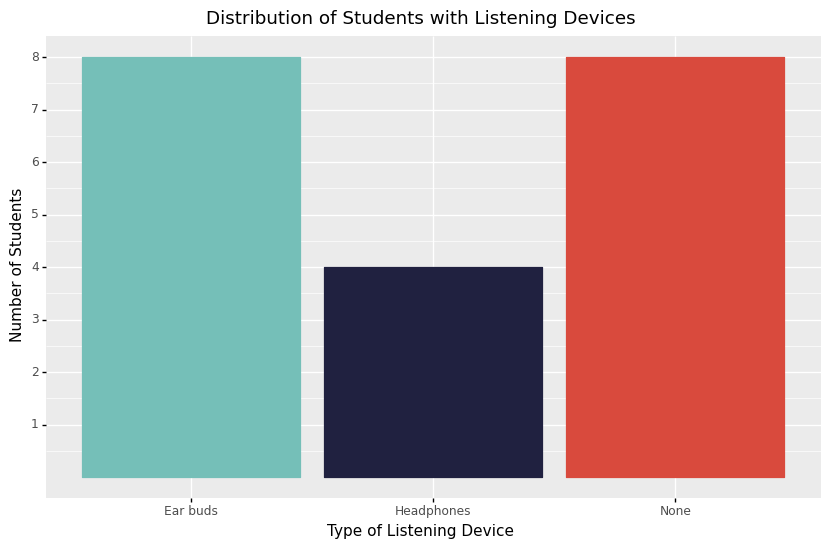

<ggplot: (8794709392044)>

In [42]:
# Visualization of students by listening devices

# Creates Color Scales
color_scale = ['#75bfb8','#202140','#d94a3d','#f2a74b']

# Creates Bar Charts Primary Colors
listening_device = (
    ggplot(listening_device_count) 
    + aes(x = 'ListeningDevice', y = 'counts',color='ListeningDevice',fill='ListeningDevice')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students with Listening Devices", x="Type of Listening Device", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
    + scale_y_continuous(breaks=np.linspace(1,listening_device_count['counts'].max(),num=listening_device_count['counts'].max()))

)
listening_device
#ggsave(listening_device,'listening_device.png')

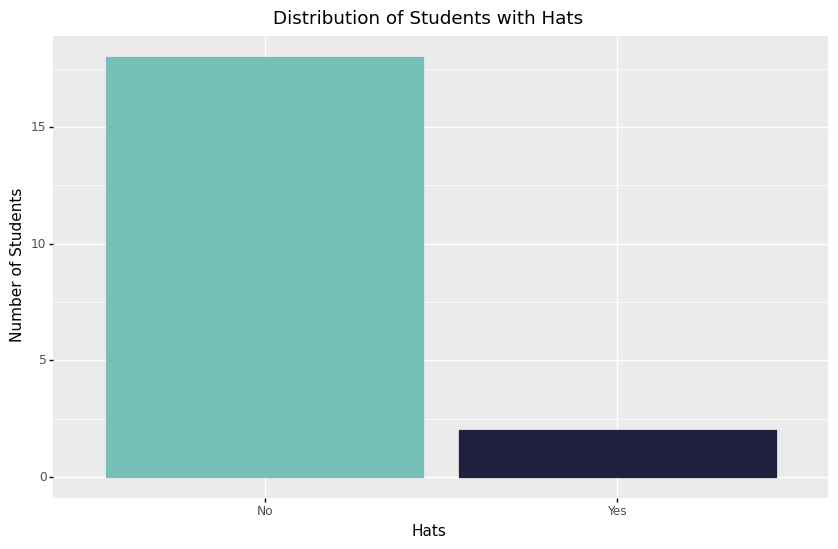

<ggplot: (8794709428661)>

In [43]:
# Visualization of students by hats

# Creates Color Scales
color_scale = ['#75bfb8','#202140']

# Creates Bar Charts Primary Colors
hat = (
    ggplot(hat_count) 
    + aes(x = 'Hat', y = 'counts',color='Hat',fill='Hat')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students with Hats", x="Hats", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
)
hat
#ggsave(hat,'hat.png')

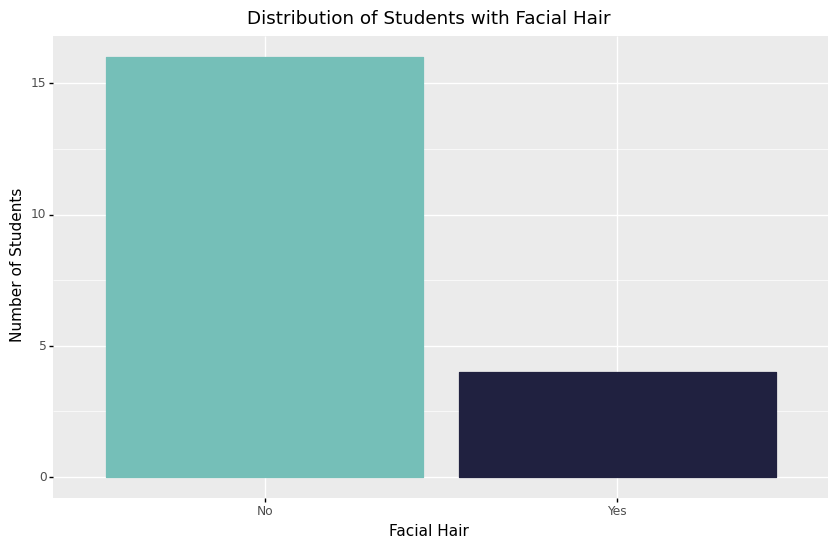

<ggplot: (8794709422523)>

In [44]:
# Visualization of students with facial hair

# Creates Color Scales
color_scale = ['#75bfb8','#202140']

# Creates Bar Charts Primary Colors
facial_hair = (
    ggplot(facial_hair_count) 
    + aes(x = 'FacialHair', y = 'counts',color='FacialHair',fill='FacialHair')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students with Facial Hair", x="Facial Hair", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
)
facial_hair
#ggsave(facial_hair,'facial_hair.png')

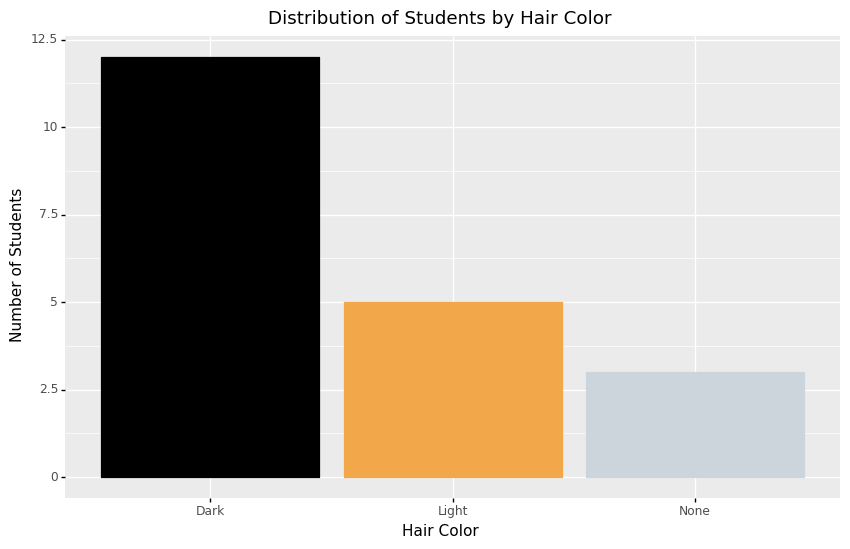

<ggplot: (8794709576985)>

In [45]:
# Visualization of students by hair color

# Creates Color Scales
color_scale = ['#000000','#f2a74b','#CDD5DC']

# Creates Bar Charts Primary Colors
hair_color = (
    ggplot(hair_color_count) 
    + aes(x = 'HairColor', y = 'counts',color='HairColor',fill='HairColor')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students by Hair Color", x="Hair Color", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
)
hair_color
#ggsave(hair_color,'hair_color.png')

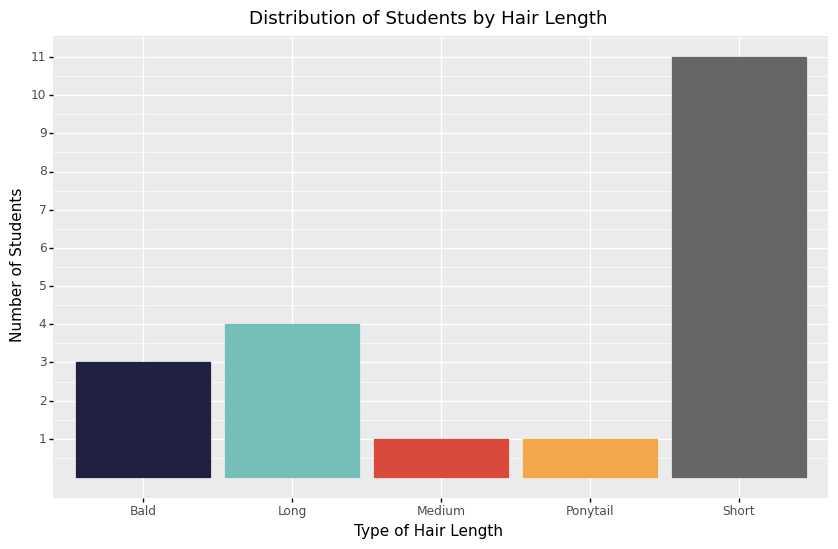

<ggplot: (8794709842713)>

In [46]:
# Visualization of students by hair length

# Creates Color Scales
color_scale = ['#202140','#75bfb8','#d94a3d','#f2a74b','#666666']

# Creates Bar Charts Primary Colors
hair_length = (
    ggplot(hair_length_count) 
    + aes(x = 'HairLength', y = 'counts',color='HairLength',fill='HairLength')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students by Hair Length", x="Type of Hair Length", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
    + scale_y_continuous(breaks=np.linspace(1,hair_length_count['counts'].max(),num=hair_length_count['counts'].max()))
)
hair_length
#ggsave(hair_length,'hair_length.png')

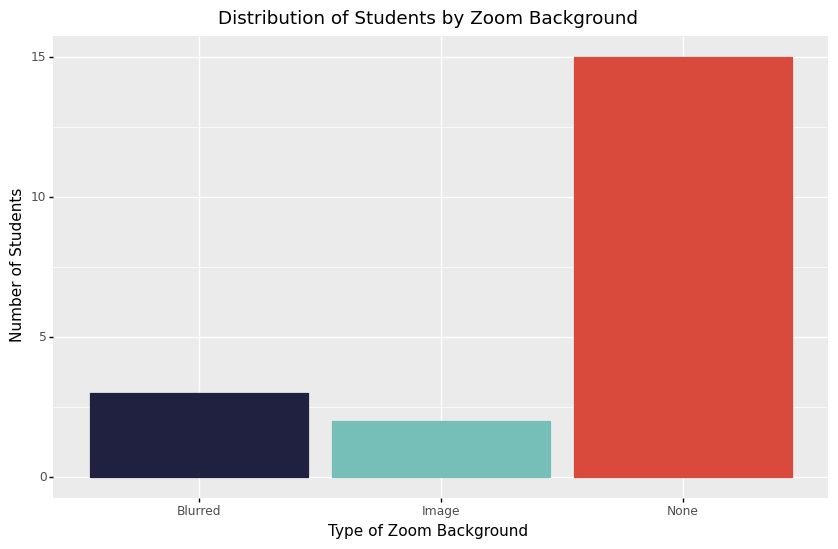

<ggplot: (8794707338322)>

In [47]:
# Visualization of students by zoom background

# Creates Color Scales
color_scale = ['#202140','#75bfb8','#d94a3d']

# Creates Bar Charts Primary Colors
zoom_background = (
    ggplot(zoom_background_count) 
    + aes(x = 'ZoomBackground', y = 'counts',color='ZoomBackground',fill='ZoomBackground')
    + geom_bar(stat="identity")
    + labs(title="Distribution of Students by Zoom Background", x="Type of Zoom Background", y = "Number of Students") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6))
)
zoom_background
#ggsave(zoom_background,'zoom_background.png')

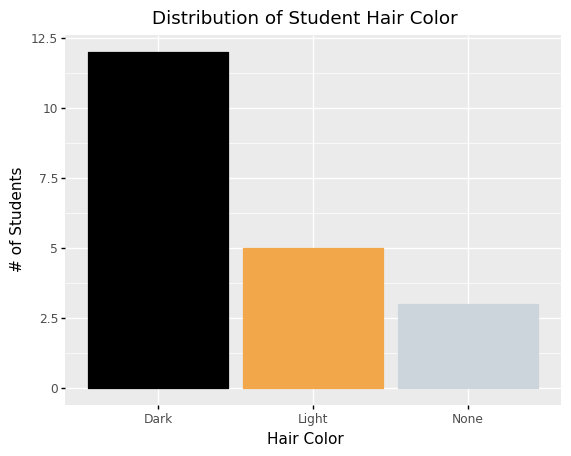

<ggplot: (8794709844008)>

In [48]:
#Creates Color Scales
colors = ['#000000','#f2a74b','#CDD5DC']

#Creates Bar Charts Primary Colors
(
    ggplot(roster) 
    + aes(x = 'HairColor', color='HairColor', fill = 'HairColor')
    + geom_bar()
    + labs(title="Distribution of Student Hair Color", x="Hair Color", y = "# of Students") # Change title and labels
    + theme(legend_position = "none") #Remove legend
    + scale_fill_manual(values=colors)
    + scale_color_manual(values=colors)
)

In [62]:
# Modify column heading from correctName to Shorthand
models = models.rename(columns={'correctName': 'Shorthand'})

# Merge the model accuracy data with the roster data
master = roster.merge(models, how='inner', on='Shorthand')
master


,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Model
0,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,77.27,Random Forest
1,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,50.00,Bayes
2,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,77.27,kNN
3,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,100.00,CNN
4,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,76.14,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,68.18,Random Forest
96,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,40.91,Bayes
97,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,72.73,kNN
98,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,100.00,CNN


In [63]:
master2 = master[master['Model']!='Average']
master2

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Model
0,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,77.27,Random Forest
1,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,50.00,Bayes
2,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,77.27,kNN
3,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,100.00,CNN
5,Christian,Bendillo,Christian Bendillo,christi,No,Headphones,No,Yes,Dark,Short,None,100.00,Random Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Nick,Waine,Nick Waine,nickwai,No,None,No,No,Dark,Short,None,100.00,CNN
95,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,68.18,Random Forest
96,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,40.91,Bayes
97,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,72.73,kNN


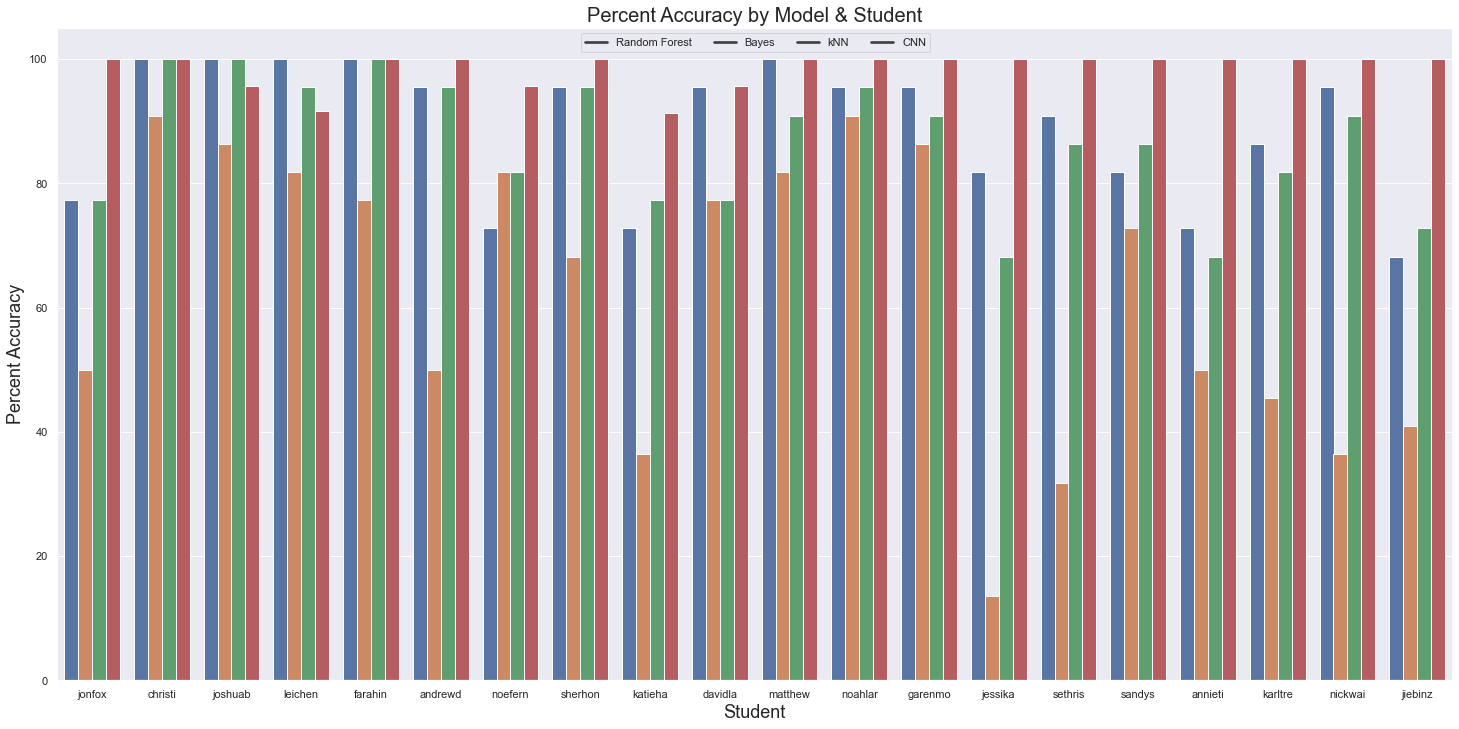

In [64]:
# Plot percent accuracy by model and student
import seaborn as sns 
# Define figure
fig, ax = plt.subplots(1, figsize=(25, 12))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.set(font_scale = 1)
sns.barplot(x='Shorthand', y='pctCorrect', hue='Model', data=master2) 
plt.title('Percent Accuracy by Model & Student',size=20)
plt.xlabel('Student',size=18)
plt.ylabel("Percent Accuracy",size=18)
plt.legend(["Random Forest", "Bayes", "kNN",'CNN'], bbox_to_anchor =(0.63, 1), ncol = 4);

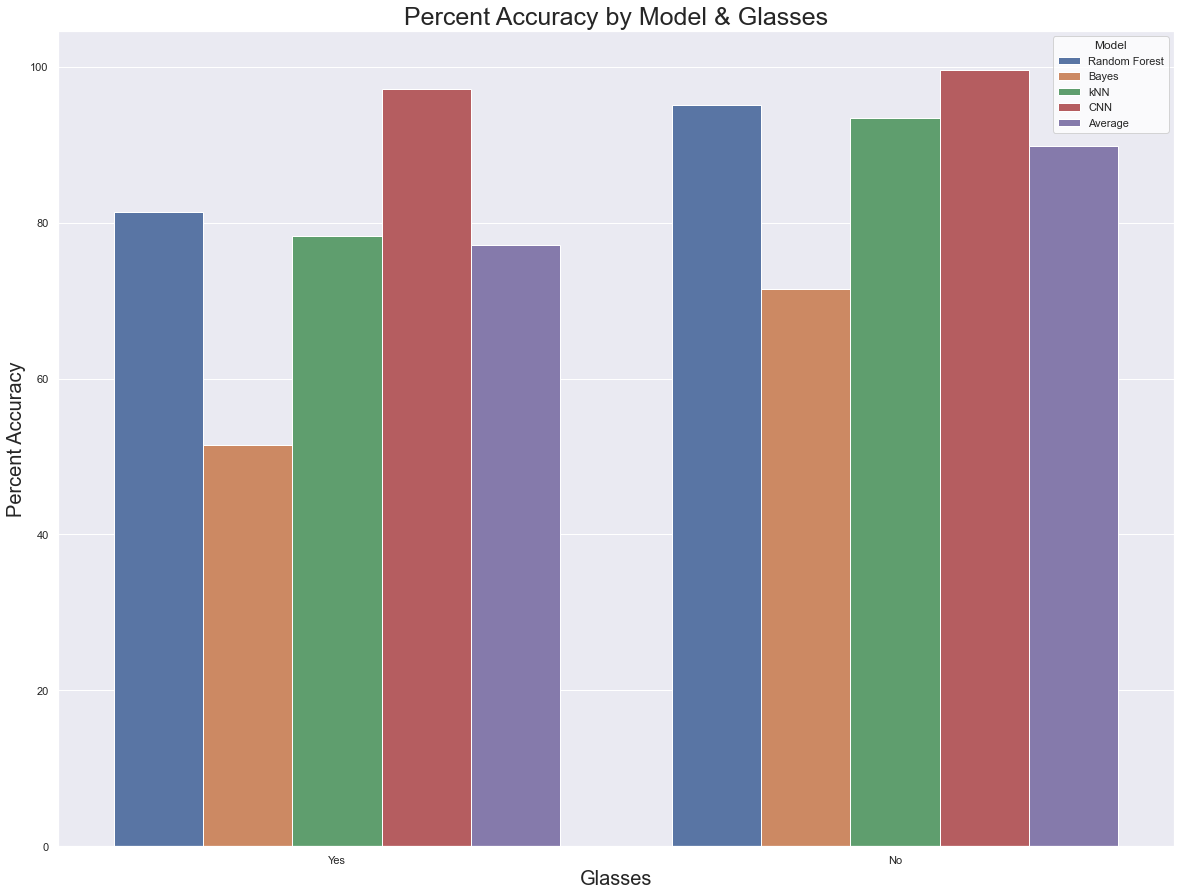

In [65]:
# Plot percent accuracy by model and glasses

# Define figure
fig, ax = plt.subplots(1, figsize=(20, 15))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Glasses', y='pctCorrect', hue='Model', data=master,ci=None) 
plt.title('Percent Accuracy by Model & Glasses',size=25)
plt.xlabel('Glasses',size=20)
plt.ylabel("Percent Accuracy",size=20)
sns.set(font_scale = 1.7)

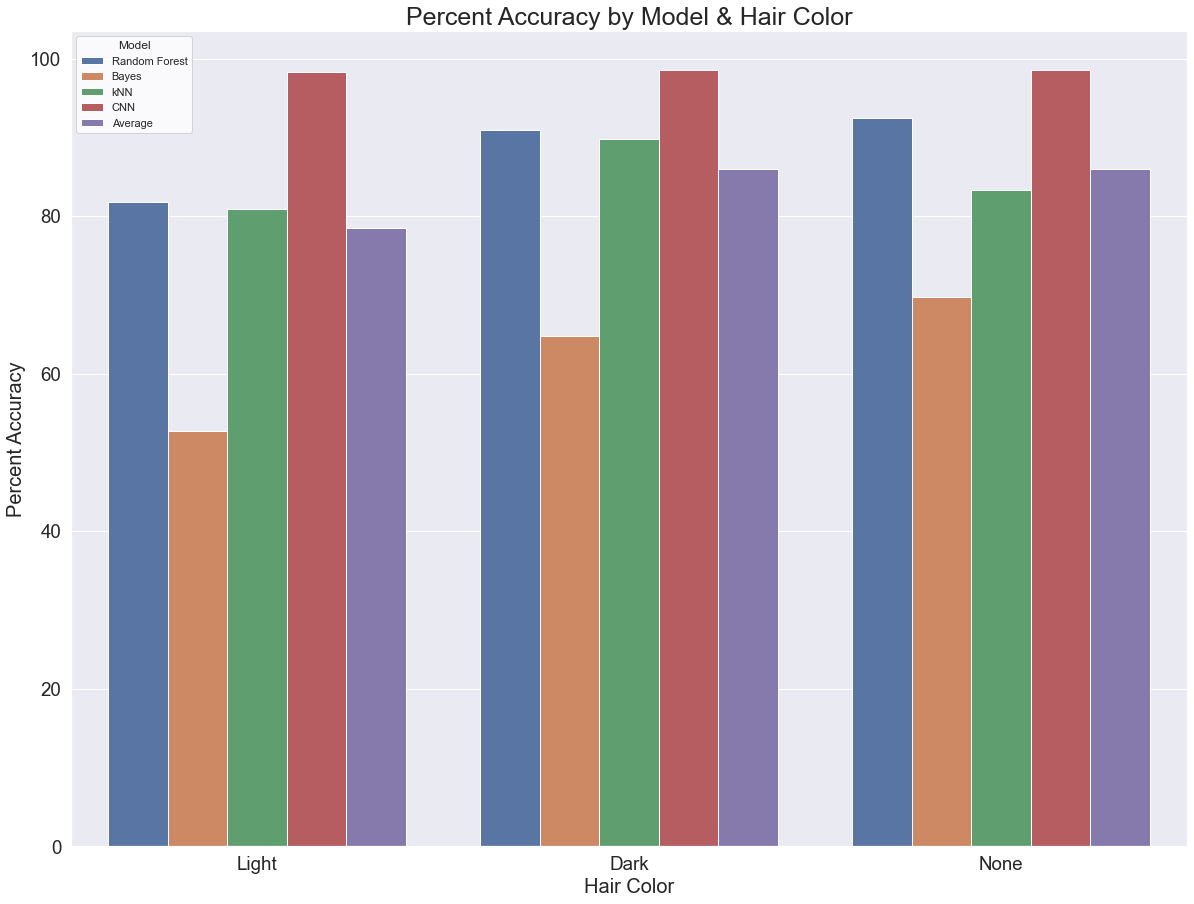

In [66]:
# Plot percent accuracy by model and hair color

# Define figure
fig, ax = plt.subplots(1, figsize=(20, 15))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='HairColor', y='pctCorrect', hue='Model', data=master,ci=None) 
plt.title('Percent Accuracy by Model & Hair Color',size=25)
plt.xlabel('Hair Color',size=20)
plt.ylabel("Percent Accuracy",size=20)
sns.set(font_scale = 1.7)

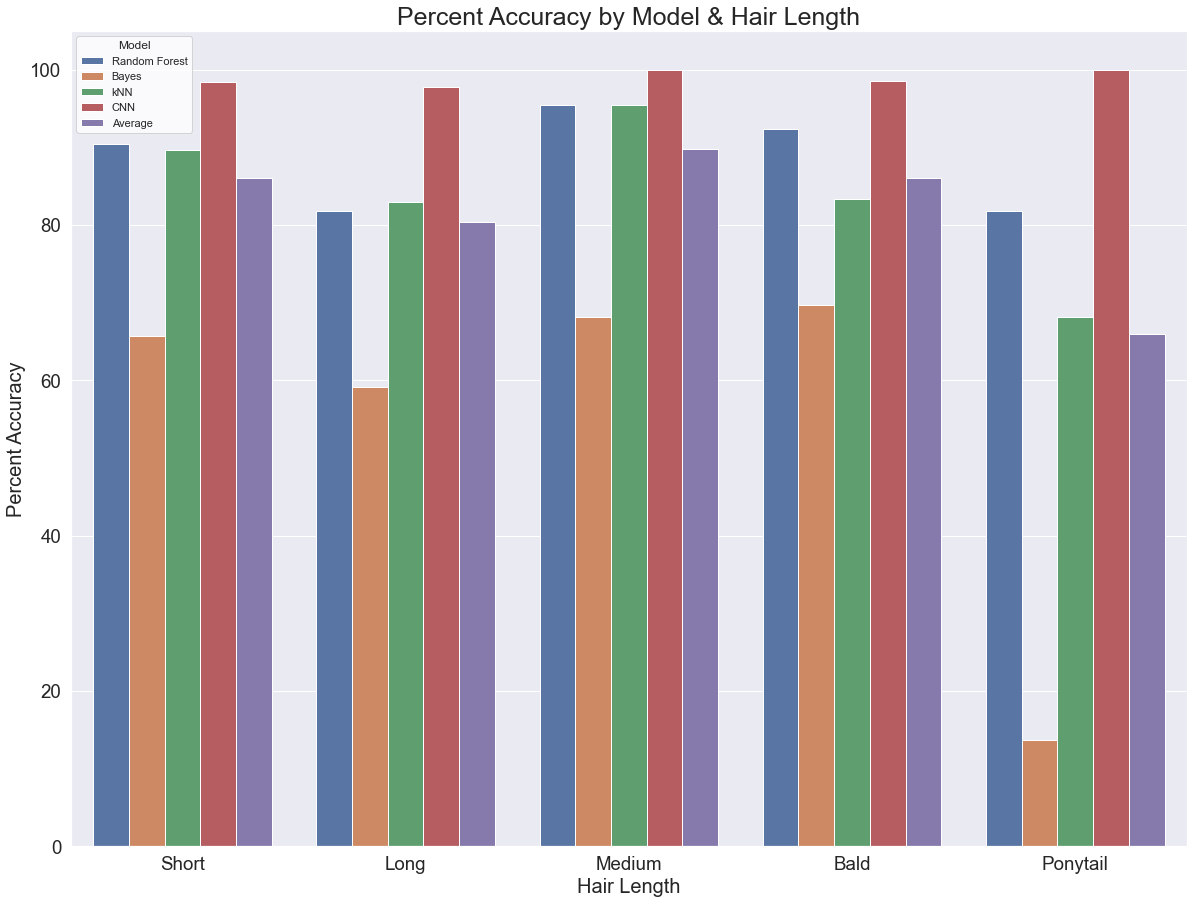

In [67]:
# Plot percent accuracy by model and hair length

# Define figure
fig, ax = plt.subplots(1, figsize=(20, 15))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='HairLength', y='pctCorrect', hue='Model', data=master,ci=None) 
plt.title('Percent Accuracy by Model & Hair Length',size=25)
plt.xlabel('Hair Length',size=20)
plt.ylabel("Percent Accuracy",size=20)
sns.set(font_scale = 1.7)

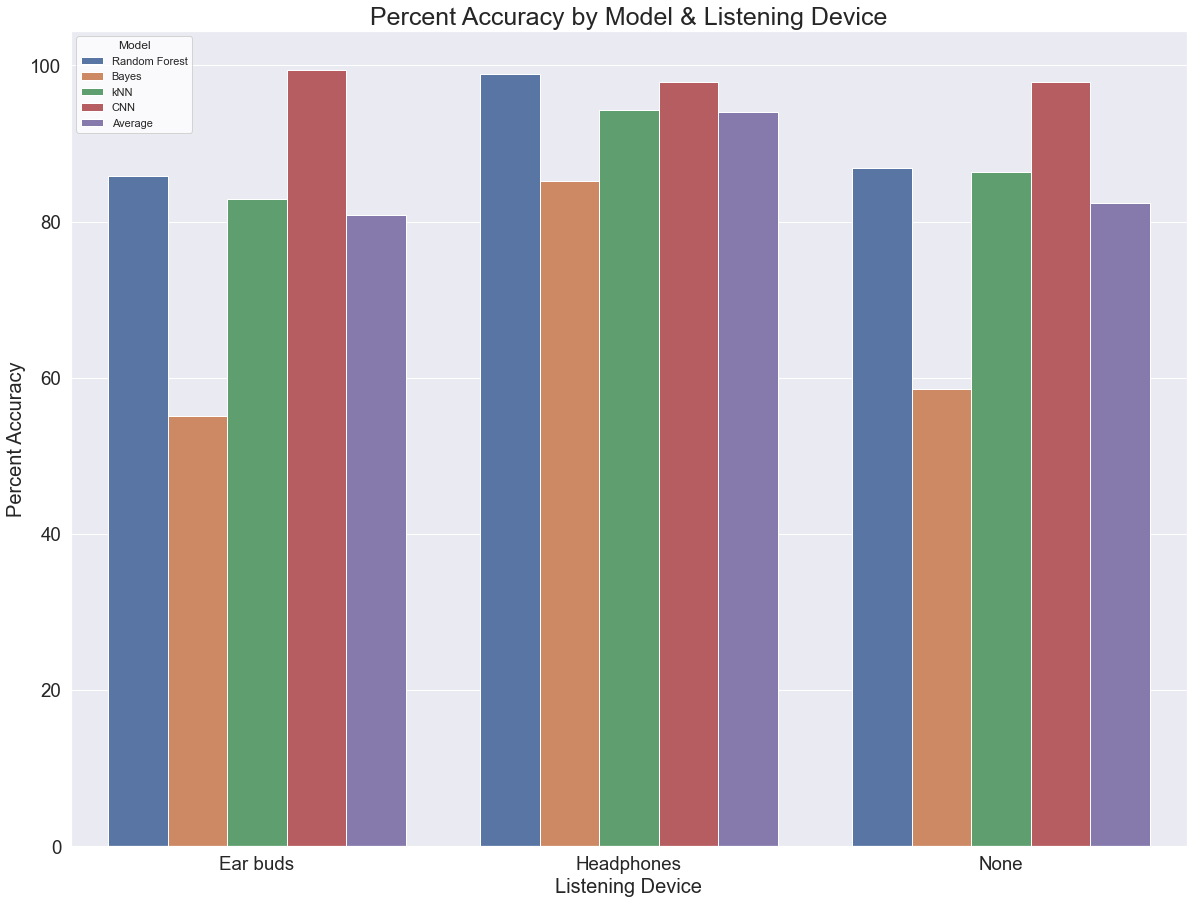

In [68]:
# Plot percent accuracy by model and listening device

# Define figure
fig, ax = plt.subplots(1, figsize=(20, 15))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='ListeningDevice', y='pctCorrect', hue='Model', data=master,ci=None) 
plt.title('Percent Accuracy by Model & Listening Device',size=25)
plt.xlabel('Listening Device',size=20)
plt.ylabel("Percent Accuracy",size=20)
sns.set(font_scale = 1.7)

In [69]:
pct_acc = master.groupby('Shorthand')['pctCorrect'].mean().reset_index()
pct_acc.head()

,Shorthand,pctCorrect
0,andrewd,85.226
1,annieti,72.728
2,christi,97.728
3,davidla,86.410
4,farahin,94.318


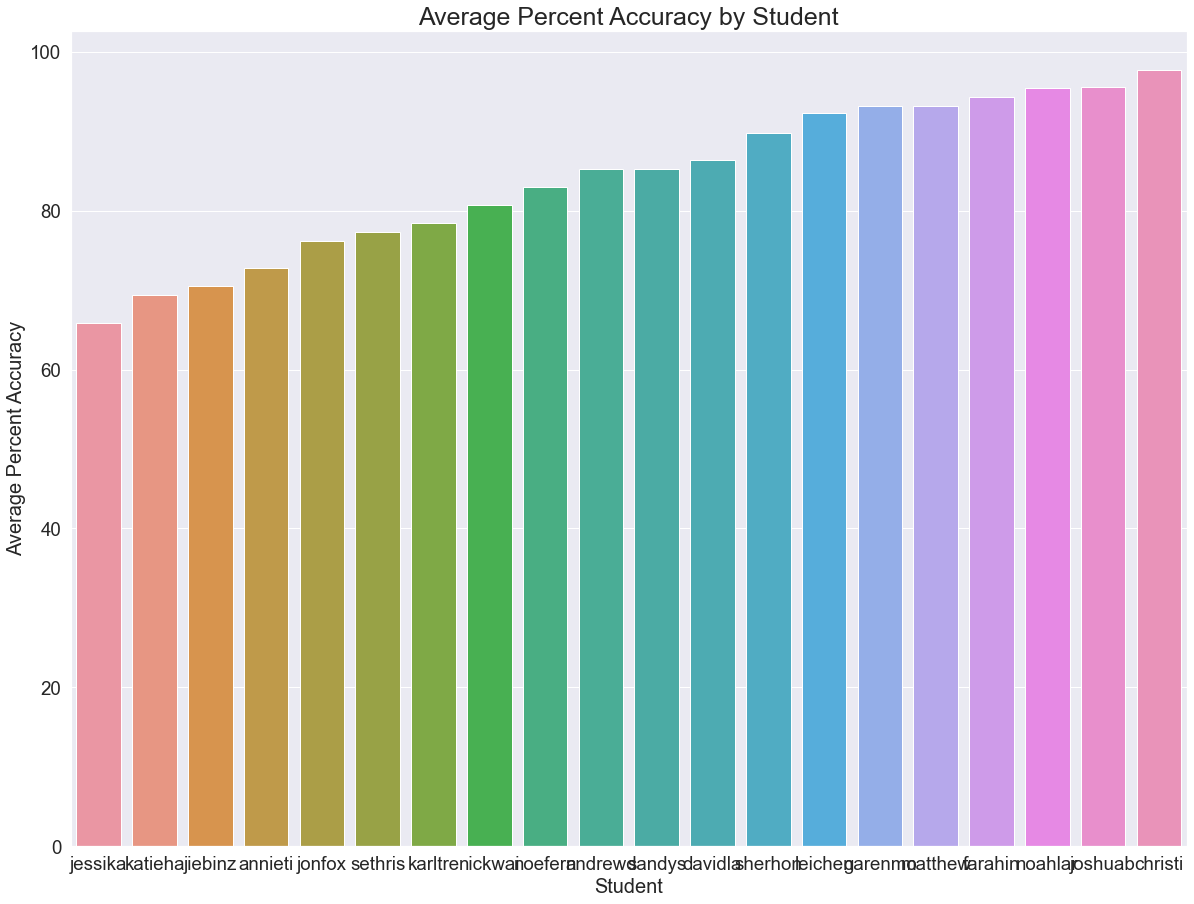

In [70]:
# Define figure
fig, ax = plt.subplots(1, figsize=(20, 15))

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Shorthand', y='pctCorrect', data=pct_acc,ci=None, order=pct_acc.sort_values('pctCorrect').Shorthand) 
plt.title('Average Percent Accuracy by Student',size=25)
plt.xlabel('Student',size=20)
plt.ylabel("Average Percent Accuracy",size=20)
sns.set(font_scale = 1)

In [71]:
master_avg = master[master['Model']=='Average']
master_avg

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Model
4,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,76.14,Average
9,Christian,Bendillo,Christian Bendillo,christi,No,Headphones,No,Yes,Dark,Short,None,97.73,Average
14,Joshua,Biggs-Bauer,Joshua Biggs-Bauer,joshuab,No,Ear buds,No,No,Dark,Short,Blurred,95.50,Average
19,Lei,Cheng,Lei Cheng,leichen,Yes,Headphones,No,No,Dark,Short,None,92.23,Average
24,Farahin,Choudhury,Farahin Choudhury,farahin,No,None,No,No,Dark,Long,None,94.32,Average
29,Andrew,Dobkowski,Andrew Dobkowski,andrewd,No,None,Yes,Yes,Dark,Short,Blurred,85.23,Average
34,Noe,Fernandes,Noe Fernandes,noefern,Yes,None,No,No,Dark,Short,None,83.01,Average
39,Sherhone,Grant,Sherhone Grant,sherhon,No,None,No,No,Dark,Medium,None,89.77,Average
44,Katie,Haugh,Katie Haugh,katieha,Yes,None,No,No,Light,Long,None,69.42,Average
49,David,Ladd,David Ladd,davidla,Yes,None,No,No,None,Bald,Blurred,86.41,Average


In [72]:
# Look at demographics for top 5 accuracy
first = roster[roster['Shorthand']=='christi']
second = roster[roster['Shorthand']=='joshuab']
third = roster[roster['Shorthand']=='noahlar']
fourth = roster[roster['Shorthand']=='farahin']
fifth = roster[roster['Shorthand']=='matthew']

top2 = first.append(second,ignore_index = True)
top3 = top2.append(third,ignore_index=True)
top4 = top3.append(fourth,ignore_index=True)
top5 = top4.append(fifth,ignore_index=True)

# Merge pct accuracy
top5_merge = top5.merge(master_avg,how='inner')
top5_merge['Accuracy Flag'] = 'Top 5'
top5_merge.head()

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Model,Accuracy Flag
0,Christian,Bendillo,Christian Bendillo,christi,No,Headphones,No,Yes,Dark,Short,None,97.73,Average,Top 5
1,Joshua,Biggs-Bauer,Joshua Biggs-Bauer,joshuab,No,Ear buds,No,No,Dark,Short,Blurred,95.50,Average,Top 5
2,Noah,Laraway,Noah Laraway,noahlar,No,Ear buds,No,No,Light,Short,None,95.45,Average,Top 5
3,Farahin,Choudhury,Farahin Choudhury,farahin,No,None,No,No,Dark,Long,None,94.32,Average,Top 5
4,Matthew,Laken,Matthew Laken,matthew,No,Headphones,No,Yes,Dark,Short,None,93.18,Average,Top 5


In [73]:
# Look at demographics for bottom 3 accuracy
last = roster[roster['Shorthand']=='jessika']
secondlast = roster[roster['Shorthand']=='katieha']
thirdlast = roster[roster['Shorthand']=='jiebinz']
fourthlast = roster[roster['Shorthand']=='annieti']
fifthlast = roster[roster['Shorthand']=='jonfox']

bottom2 = last.append(secondlast,ignore_index = True)
bottom3 = bottom2.append(thirdlast,ignore_index=True)
bottom4 = bottom3.append(fourthlast,ignore_index=True)
bottom5 = bottom4.append(fifthlast,ignore_index=True)

# Merge pct accuracy
bottom5_merge = bottom5.merge(pct_acc,how='inner')
bottom5_merge['Accuracy Flag'] = 'Bottom 5'
bottom5_merge.head()

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Accuracy Flag
0,Jessika,Pietryka,Jessika Pietryka,jessika,Yes,Ear buds,No,No,Light,Ponytail,None,65.910,Bottom 5
1,Katie,Haugh,Katie Haugh,katieha,Yes,None,No,No,Light,Long,None,69.416,Bottom 5
2,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,70.456,Bottom 5
3,Annie,Titus,Annie Titus,annieti,Yes,Ear buds,No,No,Dark,Long,Image,72.728,Bottom 5
4,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,76.136,Bottom 5


In [74]:
# Merge top 5 and bottom 5
top_and_bottom = top5_merge.append(bottom5_merge)
top_and_bottom

,FirstName,LastName,FullName,Shorthand,Glasses,ListeningDevice,Hat,FacialHair,HairColor,HairLength,ZoomBackground,pctCorrect,Model,Accuracy Flag
0,Christian,Bendillo,Christian Bendillo,christi,No,Headphones,No,Yes,Dark,Short,None,97.730,Average,Top 5
1,Joshua,Biggs-Bauer,Joshua Biggs-Bauer,joshuab,No,Ear buds,No,No,Dark,Short,Blurred,95.500,Average,Top 5
2,Noah,Laraway,Noah Laraway,noahlar,No,Ear buds,No,No,Light,Short,None,95.450,Average,Top 5
3,Farahin,Choudhury,Farahin Choudhury,farahin,No,None,No,No,Dark,Long,None,94.320,Average,Top 5
4,Matthew,Laken,Matthew Laken,matthew,No,Headphones,No,Yes,Dark,Short,None,93.180,Average,Top 5
0,Jessika,Pietryka,Jessika Pietryka,jessika,Yes,Ear buds,No,No,Light,Ponytail,None,65.910,NaN,Bottom 5
1,Katie,Haugh,Katie Haugh,katieha,Yes,None,No,No,Light,Long,None,69.416,NaN,Bottom 5
2,Jiebin,Zhu,Jiebin Zhu,jiebinz,Yes,None,No,No,Dark,Short,Image,70.456,NaN,Bottom 5
3,Annie,Titus,Annie Titus,annieti,Yes,Ear buds,No,No,Dark,Long,Image,72.728,NaN,Bottom 5
4,Jon,Fox,Jon Fox,jonfox,Yes,Ear buds,No,No,Light,Short,None,76.136,NaN,Bottom 5


/opt/anaconda3/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


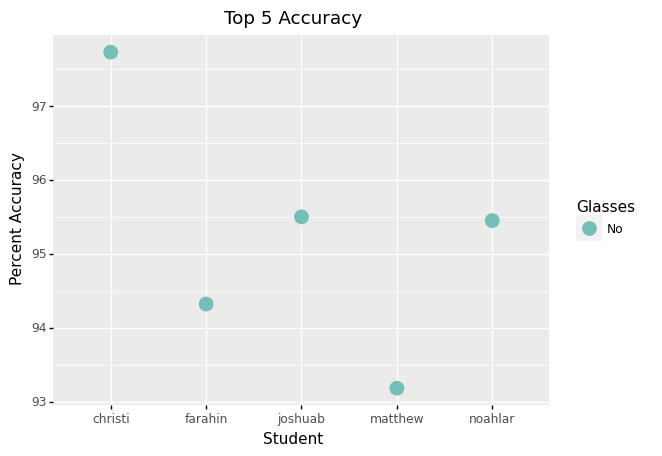

<ggplot: (8794710452667)>

In [75]:
# Create a plot that shows the top 5 accuracy and glasses

# Creates Color Scales
color_scale = ['#75bfb8']

(ggplot(top5_merge)
 + aes(x='Shorthand', y='pctCorrect', color='Glasses')
 + geom_point(size=5)
 + labs(title='Top 5 Accuracy', x='Student', y='Percent Accuracy')
  + scale_fill_manual(values=color_scale)
  + scale_color_manual(values=color_scale)
)

/opt/anaconda3/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


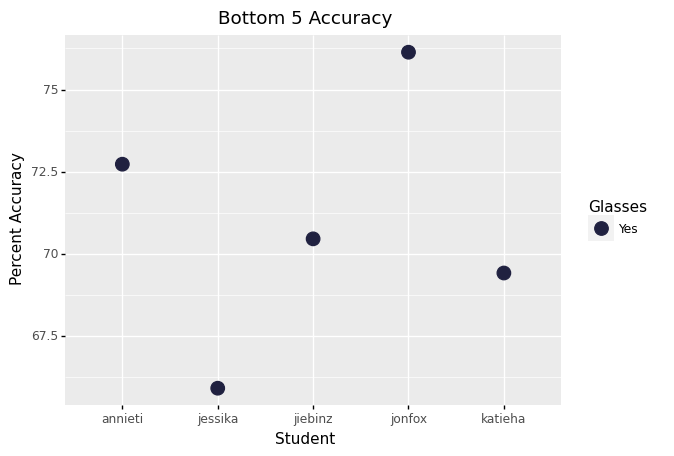

<ggplot: (8794710001125)>

In [76]:
# Create a plot that shows the bottom 5 accuracy and glasses

# Creates Color Scales
color_scale = ['#202140']

(ggplot(bottom5_merge)
 + aes(x='Shorthand', y='pctCorrect', color='Glasses')
 + geom_point(size=5)
 + labs(title='Bottom 5 Accuracy', x='Student', y='Percent Accuracy')
 + scale_fill_manual(values=color_scale)
 + scale_color_manual(values=color_scale)
)

/opt/anaconda3/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


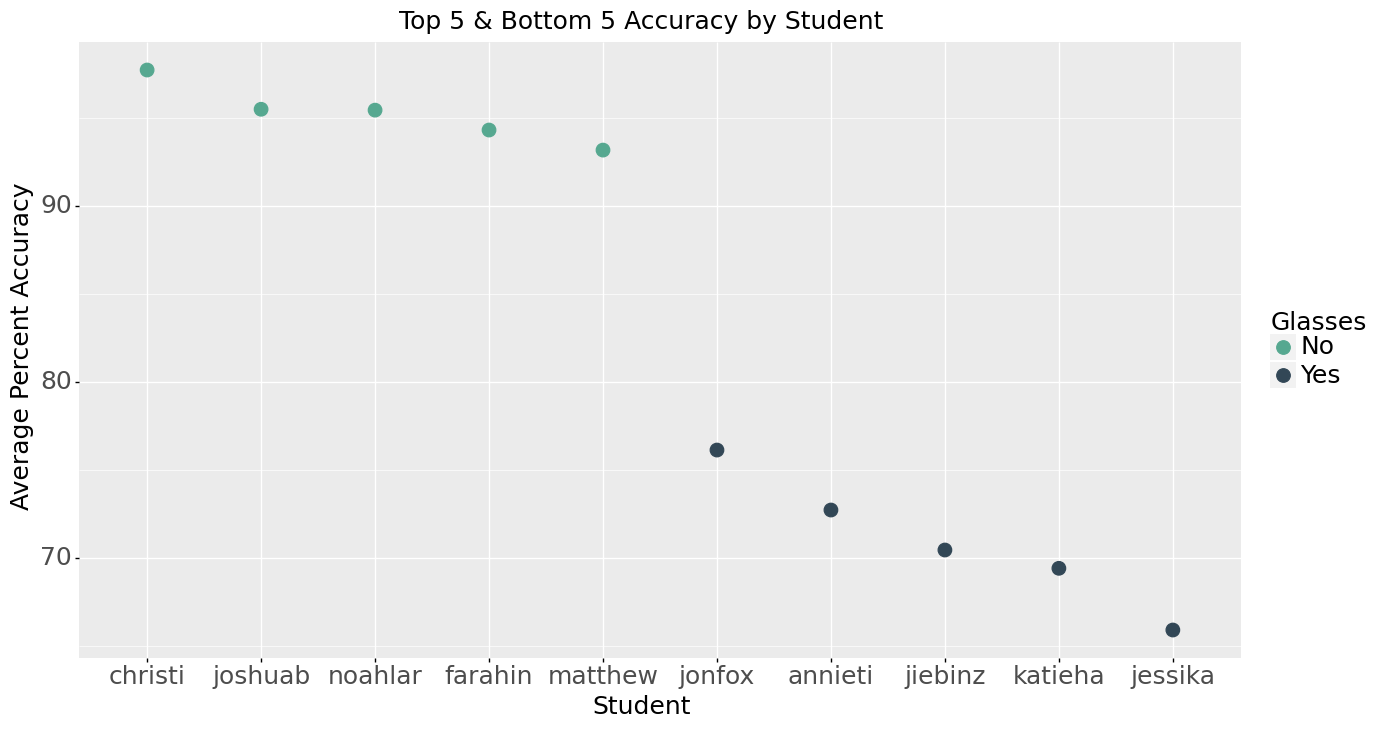

<ggplot: (8794709093072)>

In [86]:
# Create a plot that shows the top 5 accuracy and glasses

# Creates Color Scales
color_scale = ['#56A890','#324756']

(ggplot(top_and_bottom)
 + aes(x='reorder(Shorthand, -pctCorrect)', y='pctCorrect', color='Glasses')
 + geom_point(size=5)
 + labs(title='Top 5 & Bottom 5 Accuracy by Student', x='Student', y='Average Percent Accuracy')
  + scale_fill_manual(values=color_scale)
  + scale_color_manual(values=color_scale)
  + theme(figure_size=(15,8),text=element_text(size=18))
)

In [78]:
# Group by hair length accuracy
hair_length_acc = master_avg.groupby('HairLength')['pctCorrect'].mean().reset_index()
hair_length_acc.head()

,HairLength,pctCorrect
0,Bald,86.000
1,Long,80.425
2,Medium,89.770
3,Ponytail,65.910
4,Short,86.080


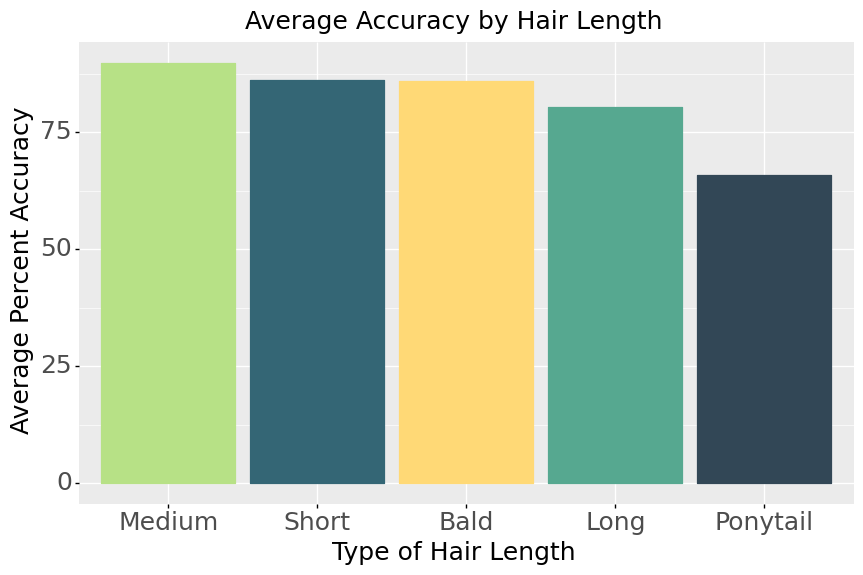

<ggplot: (8794708652960)>

In [87]:
# Visualization of average accuracy by hair length
from plotnine import *
# Creates Color Scales
color_scale = ['#FFD976','#56A890','#B7E186','#324756','#346675']

# Creates Bar Charts Primary Colors
hair_length_accuracy = (
    ggplot(hair_length_acc) 
    + aes(x = 'reorder(HairLength, -pctCorrect)', y = 'pctCorrect',color='HairLength',fill='HairLength')
    + geom_bar(stat="identity")
    + labs(title="Average Accuracy by Hair Length", x="Type of Hair Length", y = "Average Percent Accuracy") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6), text=element_text(size=18))
    + scale_y_continuous())

hair_length_accuracy
#ggsave(hair_length,'hair_length.png')

In [89]:
# Group by glasses accuracy
glasses_acc = master_avg.groupby('Glasses')['pctCorrect'].mean().reset_index()
glasses_acc.head()

,Glasses,pctCorrect
0,No,89.880000
1,Yes,77.064444


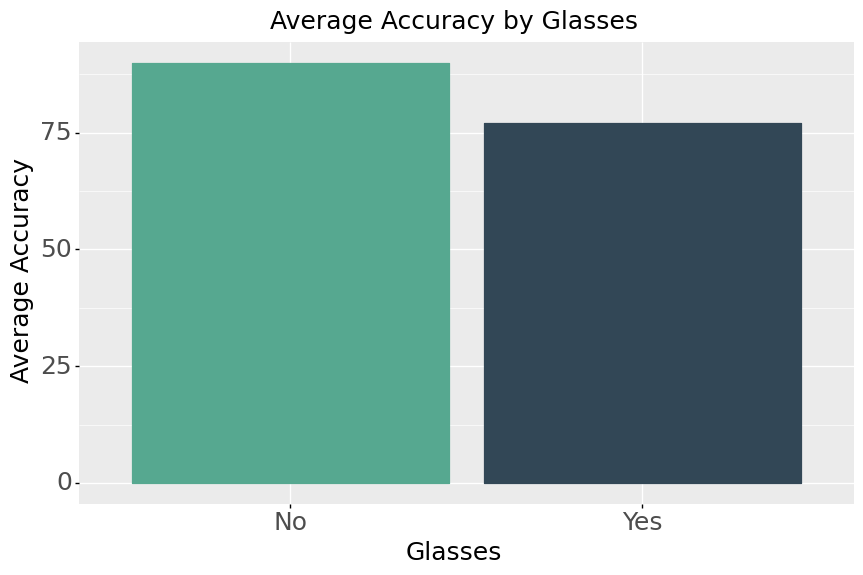

<ggplot: (8794708815776)>

In [90]:
# Visualization of accuracy for students with/without glasses

# Creates Color Scales
color_scale = ['#56A890','#324756']

# Creates Bar Charts Primary Colors
glasses_acc = (
    ggplot(glasses_acc) 
    + aes(x = 'reorder(Glasses, -pctCorrect)', y = 'pctCorrect',color='Glasses',fill='Glasses')
    + geom_bar(stat="identity")
    + labs(title="Average Accuracy by Glasses", x="Glasses", y = "Average Accuracy") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6), text=element_text(size=18))
    + scale_y_continuous()
)
glasses_acc
#ggsave(glasses,'glasses.png')

In [91]:
# Group by hat accuracy
hat_acc = master_avg.groupby('Hat')['pctCorrect'].mean().reset_index()
hat_acc.head()

,Hat,pctCorrect
0,No,84.367778
1,Yes,81.820000


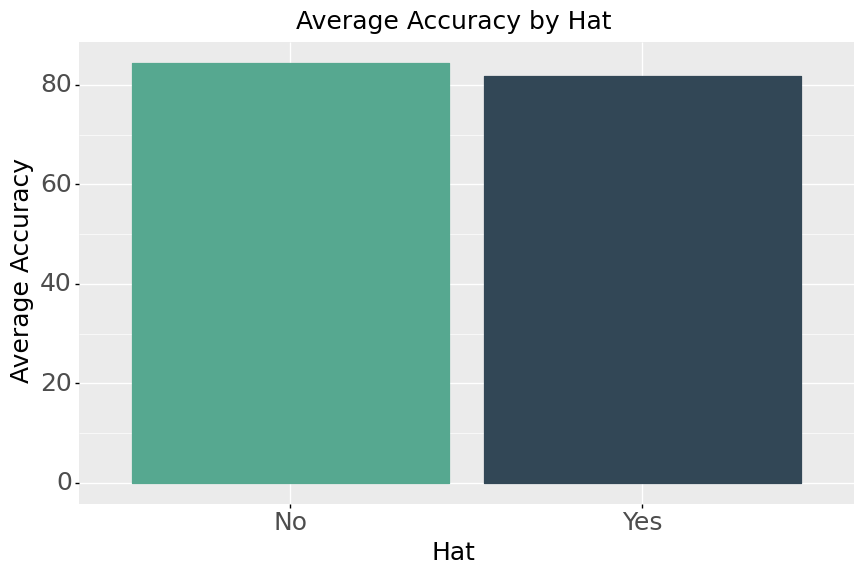

<ggplot: (8794709407507)>

In [93]:
# Visualization of accuracy for students with/without glasses

# Creates Color Scales
color_scale = ['#56A890','#324756']

# Creates Bar Charts Primary Colors
hat_accuracy = (
    ggplot(hat_acc) 
    + aes(x = 'reorder(Hat, -pctCorrect)', y = 'pctCorrect',color='Hat',fill='Hat')
    + geom_bar(stat="identity")
    + labs(title="Average Accuracy by Hat", x="Hat", y = "Average Accuracy") # Change title and labels
    + theme(legend_position = "none") # Remove legend
    + scale_fill_manual(values=color_scale)
    + scale_color_manual(values=color_scale)
    + theme(figure_size=(10, 6), text=element_text(size=18))
    #+ scale_y_continuous()
)
hat_accuracy
#ggsave(glasses,'glasses.png')